In [1]:
import fenics as f
import matplotlib.pyplot as plt
from models import velocity_field, transient_t_transport_sim, mesh_2d, t_transport_sim
import numpy as np
import scipy

In [2]:
# Generating mesh
# x1 = 0.00476
# x2 = 0.0162
# y1 = 0.01
# y2 = 0.0761
# resolution = 30
# mesh_fenics, surface_markers, left_id, top_id, right_id, bottom_id, upper_left_id, left_top_id = LMeshmshr(x1, x2, y1, y2, resolution)

mesh_fenics, volume_markers, surface_markers, correspondance_dict = mesh_2d()

T_hot = 700 + 273.15
dT = 2
T_cold = T_hot - dT

print(f"----------  Running for dT={dT} K  ----------")
foldername = f"Results_Transient/dt={dT}/"
u, p, T = velocity_field(
    T_cold=T_cold,
    T_hot=T_hot,
    my_mesh=mesh_fenics,
    surface_markers=surface_markers,
    correspondance_dict=correspondance_dict,
)

f.XDMFFile(foldername + "temperature_field.xdmf").write_checkpoint(
    T, "temperature", 1, f.XDMFFile.Encoding.HDF5
)
f.XDMFFile(foldername + "velocity_field.xdmf").write(u)

plt.figure()
plt.title("Velocity field")
CS = f.plot(u, scale=1e-3)
plt.colorbar(CS, label="m/s")
plt.axis("off")
plt.show()

plt.figure()
TS = f.plot(T, cmap="inferno")
plt.colorbar(TS, label="K")
plt.show()


TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. dolfin.cpp.mesh.Mesh()
    2. dolfin.cpp.mesh.Mesh(arg0: str)
    3. dolfin.cpp.mesh.Mesh(arg0: dolfin.cpp.mesh.Mesh)
    4. dolfin.cpp.mesh.Mesh(arg0: MPICommWrapper)
    5. dolfin.cpp.mesh.Mesh(arg0: MPICommWrapper, arg1: str)

Invoked with: <module 'dolfin.mesh' from '/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/dolfin/mesh/__init__.py'>

Salt volume : 0.0001003258390207861 m3, 100.3258390207861 mL
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/remidm/miniconda3/envs/libra-transport-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:52: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(


100.0 %        6.0e+05 s    Ellapsed time so far: 87.4 s


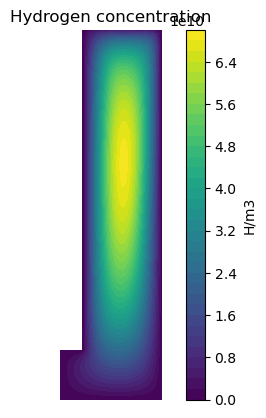

In [ ]:
top_flux, wall_flux, total_volume, t = transient_t_transport_sim(
    T,
    mesh_fenics,
    u,
    volume_markers=volume_markers,
    surface_markers=surface_markers,
    correspondance_dict=correspondance_dict,
    D_0=1.508521565198744e-08/2,  # TODO take this from HTM
    # E_D=0.23690444592353738,  # TODO take this from HTM
)

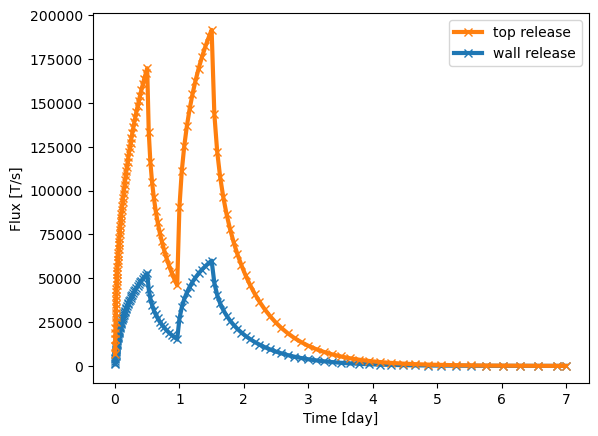

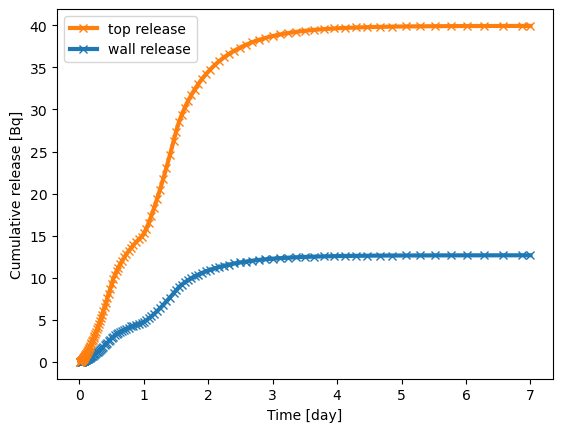

In [ ]:
tritium_specific_activity = 3.57e14  # Bq/g
tritium_molar_mass = 3.016  # g/mol
avogadro_number = 6.022e23  # mol^-1

def quantity_to_activity(quantity):
    return quantity * tritium_molar_mass * tritium_specific_activity / avogadro_number

s_to_day = 1 / 60 / 60 / 24
t = np.array(t)
plt.figure()
plt.plot(t * s_to_day, wall_flux, "-x", linewidth=3, label="wall release")
plt.plot(t * s_to_day, top_flux, "-x", linewidth=3, label="top release")
plt.ylabel("Flux [T/s]")
plt.xlabel("Time [day]")
plt.legend(reverse=True)

wall_release = scipy.integrate.cumulative_trapezoid(wall_flux, t, initial=0)
top_release = scipy.integrate.cumulative_trapezoid(top_flux, t, initial=0)

plt.figure()
plt.plot(t* s_to_day, quantity_to_activity(wall_release), "-x", linewidth=3, label="wall release")
plt.plot(t* s_to_day, quantity_to_activity(top_release), "-x", linewidth=3, label="top release")
plt.ylabel("Cumulative release [Bq]")
plt.xlabel("Time [day]")
# plt.ylim(0, 35)
plt.legend(reverse=True)
plt.show()

In [ ]:
measured_tritium_source = 3.65e5  # T/s

twelve_hr = 12 * 3600

expected_activity = quantity_to_activity(measured_tritium_source * 2 * twelve_hr)
computed_activity = quantity_to_activity(wall_release[-1] + top_release[-1] + total_volume[-1])

print(f"Expected activity: {expected_activity:.2f} Bq")
print(f"Computed activity: {computed_activity:.2f} Bq")
print(f"Total in salt at the end {total_volume[-1]:.2e} T, {quantity_to_activity(total_volume[-1]):.2e} Bq")

Expected activity: 56.39 Bq
Computed activity: 52.60 Bq
Total in salt at the end 3.06e+06 T, 5.46e-03 Bq
